In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 3.1MB 26.2MB/s 
     |████████████████████████████████| 501kB 49.6MB/s 


In [0]:
import os
import zipfile

from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
# Get Inception weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-08-16 16:15:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.1MB/s    in 3.3s    

2019-08-16 16:15:57 (25.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [0]:
# Define the model and load weights
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False,         # Get rid of the top fully cnnected layer
                                weights     = None)

pre_trained_model.load_weights(local_weights_file)

In [0]:
# Lock conv layers to keep the pre-loaded weights
for layer in pre_trained_model.layers:
    layer.trainable = False

In [0]:
# pre_trained_model.summary()  # <----- This is HUUUUGE!



In [9]:
# Check the last layer

last_layer = pre_trained_model.get_layer('mixed7')

print('Last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


In [0]:
# Go with the functional API and...

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation = 'sigmoid')(x)           

# Define the final model
model = Model(pre_trained_model.input, x) 

# Compile
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss      = 'binary_crossentropy', 
              metrics   = ['acc'])


In [11]:
# Get the data
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


--2019-08-16 16:21:04--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  36.5MB/s    in 1.8s    

2019-08-16 16:21:06 (36.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Unzip and build the folder structure

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [13]:
# Define data generators
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size  = 20,
                                                    class_mode  = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size  = 20,
                                                        class_mode  = 'binary', 
                                                        target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# Fit the model
history = model.fit_generator(train_generator,
                              validation_data  = validation_generator,
                              steps_per_epoch  = 100,
                              epochs           = 20,
                              validation_steps = 50,
                              verbose          = 2)

Epoch 1/20


W0816 16:22:34.301993 140583516096384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 - 152s - loss: 0.5140 - acc: 0.7610 - val_loss: 0.2882 - val_acc: 0.9130
Epoch 2/20
100/100 - 145s - loss: 0.3692 - acc: 0.8400 - val_loss: 0.2489 - val_acc: 0.9370
Epoch 3/20
100/100 - 143s - loss: 0.3324 - acc: 0.8540 - val_loss: 0.3211 - val_acc: 0.9290
Epoch 4/20
100/100 - 142s - loss: 0.3126 - acc: 0.8715 - val_loss: 0.4086 - val_acc: 0.9340
Epoch 5/20
100/100 - 141s - loss: 0.3160 - acc: 0.8690 - val_loss: 0.2548 - val_acc: 0.9500
Epoch 6/20
100/100 - 142s - loss: 0.3168 - acc: 0.8705 - val_loss: 0.2115 - val_acc: 0.9620
Epoch 7/20
100/100 - 141s - loss: 0.2950 - acc: 0.8765 - val_loss: 0.2364 - val_acc: 0.9570
Epoch 8/20
100/100 - 140s - loss: 0.3172 - acc: 0.8725 - val_loss: 0.3730 - val_acc: 0.9440
Epoch 9/20
100/100 - 141s - loss: 0.2998 - acc: 0.8775 - val_loss: 0.3753 - val_acc: 0.9440
Epoch 10/20
100/100 - 141s - loss: 0.2851 - acc: 0.8815 - val_loss: 0.2952 - val_acc: 0.9530
Epoch 11/20
100/100 - 140s - loss: 0.2781 - acc: 0.8845 - val_loss: 0.4058 - val_acc: 0.94

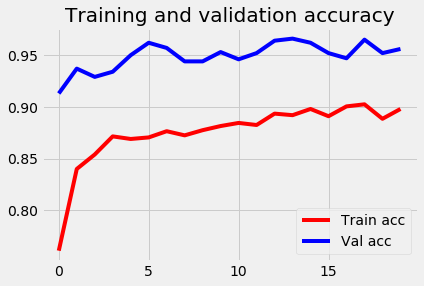

<Figure size 432x288 with 0 Axes>

In [15]:

train_acc  = history.history['acc']
val_acc    = history.history['val_acc']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs = range(len(train_acc))

plt.plot(epochs, train_acc, 'r', label = 'Train acc')
plt.plot(epochs, val_acc, 'b', label = 'Val acc')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
# Thanks inception! :)